# Tarea 3

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from datetime import datetime, timedelta
# Read csv
df = pd.read_csv('Data/PlanVital2.csv', sep=';', header=0, index_col=0)

# Cada columna a real
df = df.astype(float)
df.head()

# Sacamos los fines de semana
df['day'] = pd.to_datetime(df.index, format='%d-%m-%Y').dayofweek
df.drop(df[df['day'].isin([5,6])].index, inplace=True)
df.drop('day', axis=1, inplace=True)

# Sacamos los fondos que no usaremos 
df.drop(columns=['FONDO B', 'FONDO C', 'FONDO D'] , inplace=True)
df.head()

,FONDO A,FONDO E
Fecha,,
01-01-2015,32370.29,54351.70
02-01-2015,32317.97,54336.68
05-01-2015,32515.99,54340.52
06-01-2015,32314.83,54335.27
07-01-2015,32019.38,54331.39


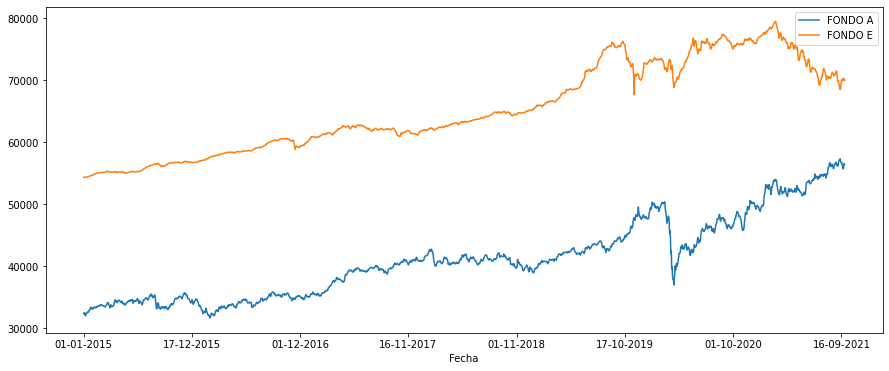

In [4]:
# Primera mirada a la evolución de los precios
df.plot(figsize=(15, 6))
plt.show()

## Cálculos preliminares

### 1. Retornos Logarítmicos

In [5]:
# Calculamos retornos logarítmicos diarios
retornos = pd.DataFrame(np.log(df.iloc[1:,:].to_numpy()/df.iloc[:-1,:].to_numpy()), columns=df.columns, index=df.index[1:])
retornos.head()

,FONDO A,FONDO E
Fecha,,
02-01-2015,-0.001618,-0.000276
05-01-2015,0.006109,0.000071
06-01-2015,-0.006206,-0.000097
07-01-2015,-0.009185,-0.000071
08-01-2015,0.003052,0.000196


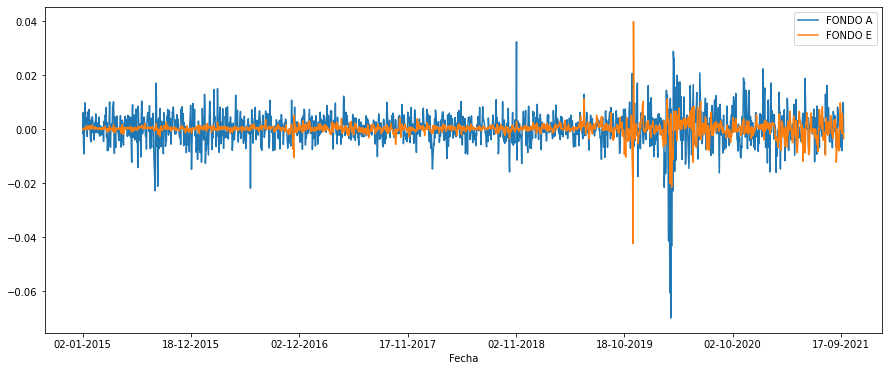

In [6]:
# Visualizamos los retornos diarios logaritmicos
retornos.plot(figsize=(15, 6))
plt.show()

<hr>
<hr>

## Parte 1

![](a.png)

Notemos que si los precios de los Fondos se pueden modelar como un MBG, entonces el logaritmo de estos, usando el lema de Ito, se puede modelar como un MBA de la siguiente forma:

$$
\delta f = \left( \mu - \frac{\sigma^2}{2} \right) \cdot \delta t + \sigma \cdot \sqrt{\delta t} \cdot \mathcal{N}(0,1)
$$

Donde $\delta f$ es simplemente $\delta ln(F)$. Podemos reescribir este modelo en versión discreta para pensar en intervalos de días:

$$
\ln(F_{t+\Delta t}) - \ln(F_{t}) = \left( \mu - \frac{\sigma^2}{2} \right) \cdot \Delta t + \sigma \cdot \sqrt{\Delta t} \cdot \mathcal{N}(0,1)
$$

Con esto, la media de los retornos logarítmicos diarios sería justamente $\mu_A = \left( \mu - \frac{\sigma^2}{2} \right)$, mientras que la volatilidad sería $\sigma_A = \sigma$, ya que estamos hablando de intervalos de un día; es decir, $\Delta t = 1$.

In [7]:
s = retornos.std()
s

FONDO A    0.006054
FONDO E    0.002718
dtype: float64

In [8]:
mu_sigma2_2 = retornos.mean()
mu = mu_sigma2_2 + s**2/ 2
mu

FONDO A    0.000335
FONDO E    0.000147
dtype: float64

<hr>
<hr>

## Parte 2

![](b.png)

Del modelo de MBA presentado en la parte 1 podemos despejar y llegar a la siguiente expresión para el precio de un Fondo:

$$
F_{t+\Delta t} = F_t \cdot \exp \left( \left( \mu - \frac{\sigma^2}{2} \right) \cdot \Delta t + \sigma \cdot \sqrt{\Delta t} \cdot \mathcal{N}(0,1) \right)
$$

Luego, un paso de un mes significa un delta en días de $\Delta t = ''dias\;en\;un\;mes''$, por lo que la simulación del precio de un Fondo en el año 35 sería, tomando como precio final el último disponible en los datos y notando que la cantidad de pasos a tomar son 420, ya que es la cantidad de meses 35 años:

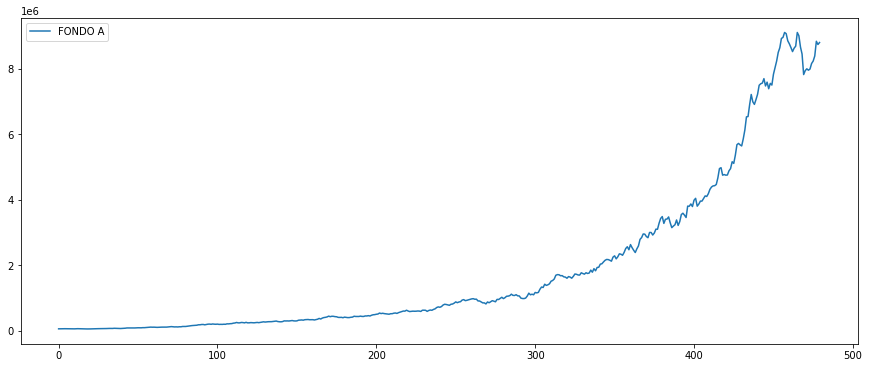

In [25]:
# Precio inicial
F_0 = df.iloc[-1,0]

# Delta meses
n_dias = retornos.shape[0]
Delta_t = n_dias // (5*12) # 5 años en la base

# Pasos
n_pasos = 12*40

# Distribución normal estándar simulada
Z = np.random.standard_normal(size=n_pasos)

# Estdísticas del fondo A
s_A = s.iloc[0]
mu_sigma2_2_A = mu_sigma2_2.iloc[0]

# Simulación del precio recursiva
F_t = F_0 # último precio
F_35 = np.zeros(n_pasos) # precios hata el 35º paso
for t in range(n_pasos):
    F_t = F_t * np.exp(mu_sigma2_2_A * Delta_t + s_A * Delta_t**0.5 * Z[t])
    F_35[t] = F_t # Agregamos el último precio

plt.figure(figsize=(15, 6))
plt.plot(F_35, c='C0')
plt.legend(['FONDO A'])
plt.show()

Luego, tenemos que hacer lo mismo para últimos 5 años en el fondo E, tomando como precio inicial el último precio de la simulación anterior, pero con 60 pasos, que es la cantidad de meses en 5 años y las estadísticas del fondo E.

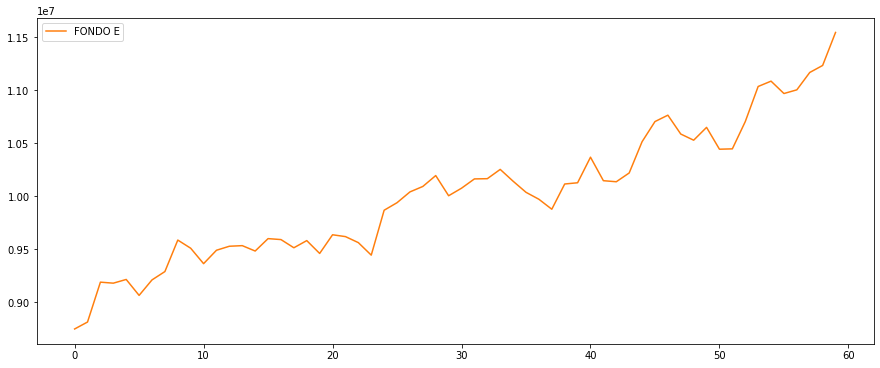

In [26]:
# Pasos
n_pasos = 60

# Distribución normal estándar simulada
Z = np.random.standard_normal(size=n_pasos)

# Estdísticas del fondo A
s_B = s.iloc[1]
mu_sigma2_2_B = mu_sigma2_2.iloc[1]

# Simulación del precio recursiva
F_t = F_35[-1] # último precio
F_5 = np.zeros(n_pasos) # precios hata el 35º paso
for t in range(n_pasos):
    F_t = F_t * np.exp(mu_sigma2_2_B * Delta_t + s_B * Delta_t**0.5 * Z[t])
    F_5[t] = F_t # Agregamos el último precio

plt.figure(figsize=(15, 6))
plt.plot(F_5, c='C1')
plt.legend(['FONDO E'])
plt.show()

Ahora combinamos ambos resultados para la simulación de los 40 años de cotizaciones en un solo arreglo.

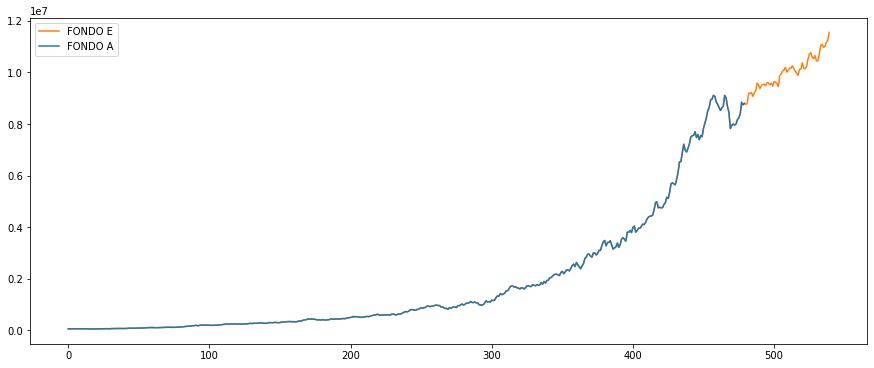

In [27]:
F_40 = np.append(F_35, F_5)

plt.figure(figsize=(15, 6))
plt.plot(F_40, c='C1', label='FONDO E')
plt.plot(F_35, c='C0', label='FONDO A')
plt.legend()
plt.show()

Repetimos el proceso $N=2000$ veces para poder generar estadísticas a partir de las simulaciones:

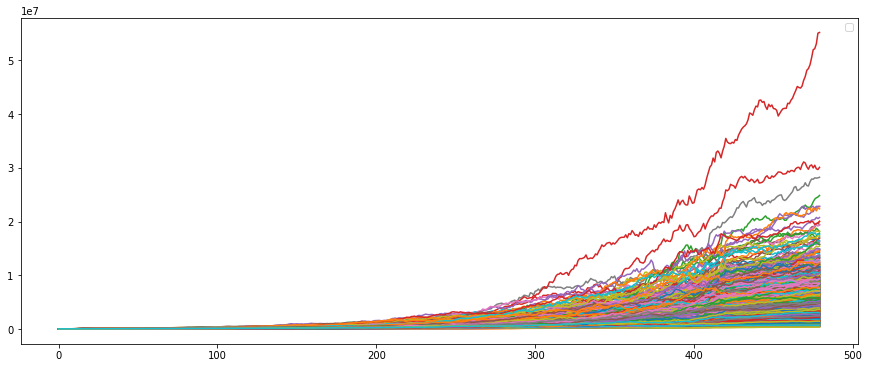

In [28]:
# Precio inicial
F_0 = df.iloc[-1,0]

# Simulaciones
N = 2000

# Delta meses
n_dias = retornos.shape[0]
Delta_t = n_dias // (5*12) # 5 años en la base

# Pasos
n_pasos = 12*40

# Distribución normal estándar simulada
Z = np.random.standard_normal(size=(n_pasos, N))


# Simulación del precio recursiva
F_t = np.zeros(N) + F_0 # último precio
F_40 = np.zeros((n_pasos, N)) # precios hata el 35º paso
for t in range(n_pasos):
    if t <= 12*35:
        F_t = F_t * np.exp(mu_sigma2_2_A * Delta_t + s_A * Delta_t**0.5 * Z[t,:])
        F_40[t,:] = F_t # Agregamos el último precio
    else:
        F_t = F_t * np.exp(mu_sigma2_2_B * Delta_t + s_B * Delta_t**0.5 * Z[t,:])
        F_40[t,:] = F_t # Agregamos el último precio      

df_40 = pd.DataFrame(F_40)

df_40.plot(figsize=(15, 6))
plt.legend([])
plt.show()

Para las estadísticas pedidas, podemos sacar media, desviación estándar, máximo, mínimo y cuantiles 25-50-75. para cada día en las simulaciones, y luego podemos graficar esto para tener una idea visual de lo que va pasando.

In [15]:
# Estadísticas básicas
stats_F = df_40.apply(pd.Series.describe, axis=1)
stats_F.head()

,count,mean,std,min,25%,50%,75%,max
0,2000.0,56974.011080,1854.472307,51127.102546,55741.340239,56940.219063,58207.434612,63385.730287
1,2000.0,57474.906390,2664.450710,48659.128206,55646.140128,57479.146765,59126.285512,65823.921781
2,2000.0,58087.719274,3258.497588,48672.090805,55903.653768,58071.742951,60116.510458,69956.964964
3,2000.0,58626.533011,3769.895554,48437.636755,56024.977934,58519.540356,61088.169214,73670.914011
4,2000.0,59240.193416,4270.955857,46381.355087,56370.041571,59094.332825,61951.090290,75161.462757


Gráfico del mínimo, los cuantiles 25-50-75 y el máximo.

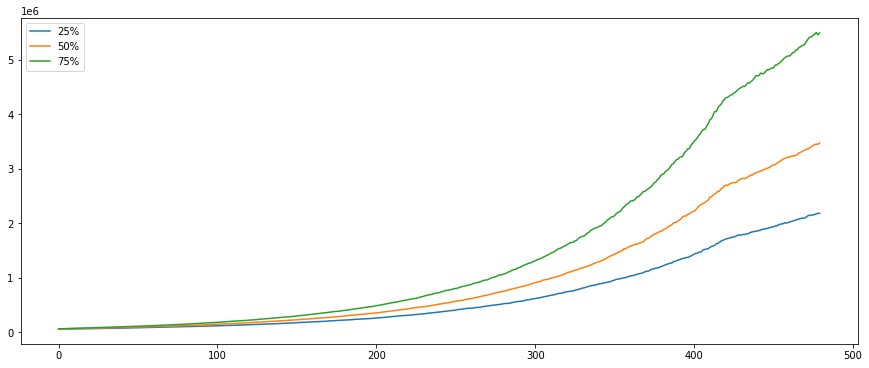

In [31]:
stats_F[[f'{25*(i+1)}%' for i in range(3)]].plot(figsize=(15, 6))
plt.show()

Este gráfico nos muestra el intervalo en el que debería estar la mitad de los datos o el intervalo en el que estará a través del tiempo la cantidad de dinero que tiene ahorrado en fondos previsionales la persona con probabilidad 0,5.

Repetimos el ejercicio, pero ahora con la media +/- una y dos desviaciones estándar, ya que, en principio, las variaciones de precio deberían seguir una normal según los supuestos de los modelos vistos. Sin embargo, como tenermos una variación en la distribución de las variaciones en los últimos 3 años al cambiar de fondo y no necesariamente se cumple el supuesto original tampco, el gráfico anterior debería ser mucho más respresentativo de la realidad como intervalo de confianza.

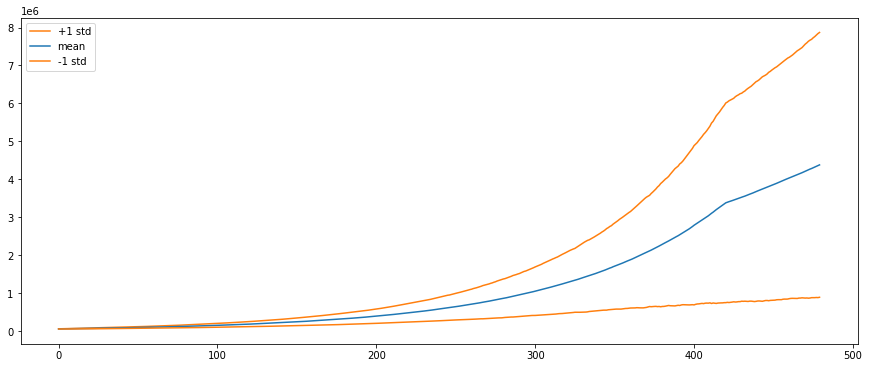

In [50]:
plt.figure(figsize=(15,6))
plt.plot(stats_F['mean']+1*stats_F['std'], c='C1', label='+1 std')
plt.plot(stats_F['mean'], c='C0', label='mean')
plt.plot(stats_F['mean']-1*stats_F['std'], c='C1', label='-1 std')
plt.legend()
plt.show()

Analicemos ahora los quintiles de la trayectoria del valor cuota de manera diaria también, para luego graficar estos y comparar con el resultado anterior.

In [47]:
quintiles_F = df_40.apply(pd.Series.describe, axis=1, args=([.2, .4, .6, .8], None, None, False))
quintiles_F.head()

,count,mean,std,min,20%,40%,50%,60%,80%,max
0,2000.0,56957.443077,1831.992450,50316.007034,55421.883053,56515.837234,56966.710404,57424.342846,58499.809351,63550.287045
1,2000.0,57485.102555,2696.558041,48797.277267,55229.610565,56765.454394,57406.712982,58111.919799,59694.125707,66279.078762
2,2000.0,58107.130359,3326.923456,47042.335277,55260.929133,57266.833598,58064.225948,58810.558747,60862.492489,68915.723379
3,2000.0,58683.708876,3903.855400,47462.309890,55401.372808,57435.895691,58485.069737,59597.363356,62037.089359,72127.163784
4,2000.0,59165.099783,4377.088609,45923.641649,55465.167787,57744.176465,58988.994619,60159.059664,62765.362401,74223.436088


Gráfico de quintiles

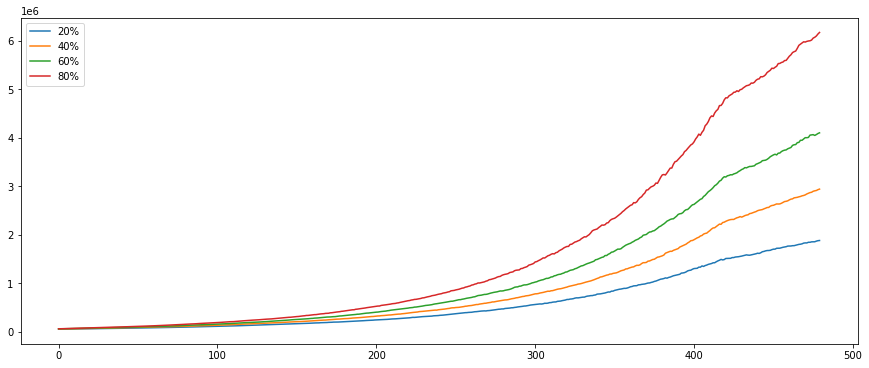

In [49]:
quintiles_F[[f'{20*(i+1)}%' for i in range(4)]].plot(figsize=(15, 6))
plt.show()

Podemos hacer ahora un comparación entre ambos gráficos anteriores, teniendo en cuenta que en una distribución normal el 6..% de los ...

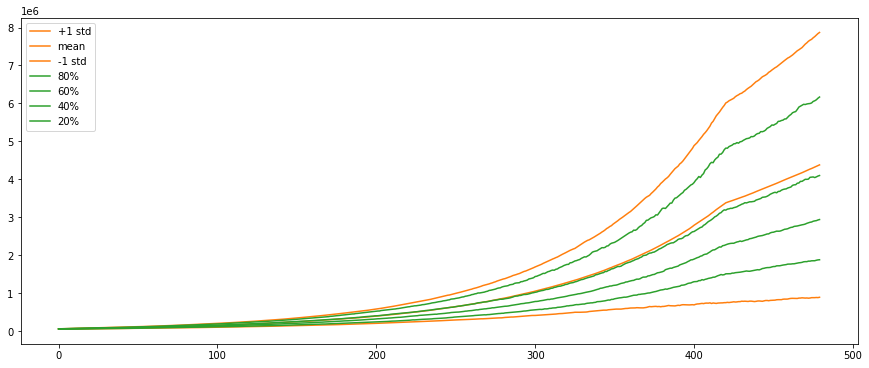

In [54]:
plt.figure(figsize=(15,6))
plt.plot(stats_F['mean']+1*stats_F['std'], c='C1', label='+1 std')
plt.plot(stats_F['mean'], c='C1', label='mean')
plt.plot(stats_F['mean']-1*stats_F['std'], c='C1', label='-1 std')
quintiles_F['80%'].plot(c='C2')
quintiles_F['60%'].plot(c='C2')
quintiles_F['40%'].plot(c='C2')
quintiles_F['20%'].plot(c='C2')
plt.legend()
plt.show()

Notamos que la media parece estar siempre en el cuarto quintil, por lo que estaría siempre por encima del 60% de los casos posibles. Dicho esto, es claro que la distribución de los precios no es de una normal, sino de alguna distribución que tenga una mayor acumulación en valores bajos y baja acumulación en valores mayores, pero que estos últimos sean los suficientemente grandes para desplazar la media por sobre el 60%, dada la diferencia existente entre media y mediana y la desviación.

Podemos visualizar de alguna manera esto con una histograma de los precios del último periodo, teniendo en cuenta que es el punto que mejor debería resumir el mix de distribuciones y donde más se notan las diferencias entre media y mediana. 

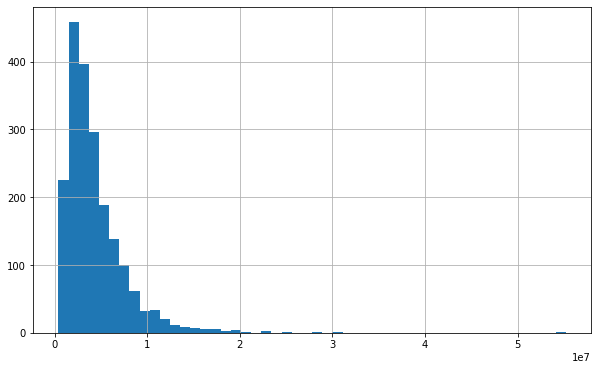

In [57]:
df_40.iloc[-1,:].hist(figsize=(10,6), bins=50)
plt.show()

<hr>
<hr>

## Parte 3

![](c.png)

In [61]:
# Sueldos
sueldos = np.zeros(n_pasos)
T_3 =  12*3
sueldos[:T_3] = 1000000 

# Aumento de 100k
for t in range(T_3, n_pasos):
    if sueldos[t-1] == 2500000:
        break
    else:
        sueldos[t] = sueldos[t-1]+100000

# Se mantiene en 2.5m
sueldos[sueldos == 0] = 2500000

# 10%
aporte = sueldos*0.1

# Cuotas asignadas según el aporte
cuotas_asignadas = np.zeros((n_pasos, N))
cuotas_asignadas[0,:] = aporte[0]/df_40.iloc[0,:]
for t in range(1,n_pasos):
    cuotas_asignadas[t,:] = cuotas_asignadas[t-1,:] + aporte[t]/df_40.iloc[t,:]

# Montos capitalizados
montos_capitalizados = pd.DataFrame((cuotas_asignadas * df_40))
montos_capitalizados.tail()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
475,1.466084e+09,1.011525e+09,5.427843e+09,6.907686e+08,5.226543e+08,1.608090e+09,7.835062e+08,1.884757e+09,3.377942e+09,1.874217e+09,...,1.131545e+09,1.737789e+09,1.959455e+09,1.671612e+09,1.029575e+09,1.339000e+09,3.345890e+09,1.607530e+09,1.425035e+09,1.281652e+09
476,1.486734e+09,9.952735e+08,5.546693e+09,7.035339e+08,5.431152e+08,1.606582e+09,7.981640e+08,1.927806e+09,3.367792e+09,1.860640e+09,...,1.134284e+09,1.745589e+09,1.991807e+09,1.646567e+09,1.013573e+09,1.348463e+09,3.339466e+09,1.636403e+09,1.444587e+09,1.280890e+09
477,1.449781e+09,1.025649e+09,5.603320e+09,7.271836e+08,5.597680e+08,1.645072e+09,8.186148e+08,1.930902e+09,3.357496e+09,1.892000e+09,...,1.145462e+09,1.734677e+09,1.995073e+09,1.659924e+09,1.014801e+09,1.363790e+09,3.324335e+09,1.597943e+09,1.457091e+09,1.277502e+09
478,1.452794e+09,1.042136e+09,5.637503e+09,7.177992e+08,5.698743e+08,1.657004e+09,8.204560e+08,1.913687e+09,3.365811e+09,1.902785e+09,...,1.165161e+09,1.776426e+09,2.011658e+09,1.688647e+09,1.003474e+09,1.391317e+09,3.350644e+09,1.611890e+09,1.495492e+09,1.283030e+09
479,1.465239e+09,1.045085e+09,5.704213e+09,7.086298e+08,5.641506e+08,1.675077e+09,8.378134e+08,1.921250e+09,3.334094e+09,1.956256e+09,...,1.179234e+09,1.742500e+09,2.014208e+09,1.662051e+09,1.014961e+09,1.403448e+09,3.293405e+09,1.634259e+09,1.487885e+09,1.271834e+09


Luego, como en este caso 

In [ ]:
# Estadísticas básicas
monto_final = montos_capitalizados.iloc[-1,:]
monto_final.describe()

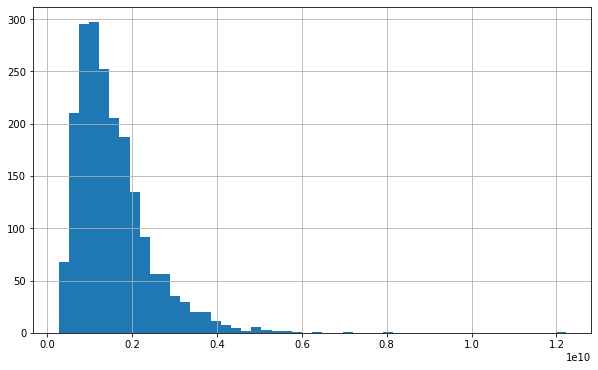

In [59]:
# Histograma
monto_final.hist(figsize=(10,6), bins=50)
plt.show()